In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import random
import cv2

2025-06-13 13:12:06.710706: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 13:12:06.714931: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 13:12:06.763321: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-13 13:12:06.817365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749831126.868323   76749 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749831126.88

In [3]:
data_path = "MangoLeaf"
img_size = (224,224)
batch_size = 32
mode = "rgb"

In [4]:
model = tf.keras.models.load_model("models/efficientNetB0.keras")

E0000 00:00:1749831534.989864   76749 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749831534.990302   76749 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# Função para processar e avaliar cada banco corrompido
import pandas as pd
import numpy as np
import os
from tensorflow import keras

def funcaoParaObterAcuraciaParaMultiClasses(verdade, predicao, numeroDeClasses, ImagensPorClasse):
    
    vetorAuxiliar = [0 for _ in range(numeroDeClasses)]

    for i in range(0, len(predicao)):
        if verdade[i] == predicao[i]:
            vetorAuxiliar[verdade[i]] = vetorAuxiliar[(verdade[i])] + 1

    vetorDeAcuracia = [0, 0, 0, 0, 0, 0, 0, 0]
    
        
    for i in range(0, len(vetorAuxiliar)):
        vetorDeAcuracia[i] = vetorAuxiliar[i]/ImagensPorClasse
        
    return vetorDeAcuracia



def df_maker(path):
    file_paths = []
    labels = []

    # Listando as pastas dentro do diretório base (representam as classes)
    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path, fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path, file)
            file_paths.append(file_path)
            labels.append(fold)

    # Criando uma série para caminhos e rótulos
    file_series = pd.Series(file_paths, name="file_paths")
    label_series = pd.Series(labels, name="labels")

    # Concatenando as séries para formar um dataframe
    df = pd.concat([file_series, label_series], axis=1)
    return df



def evaluate_corrupted_model(model, corrupted_data_path, corruption_name):
    # Cria o dataframe com o caminho das imagens e rótulos
    corrupted_df = df_maker(corrupted_data_path)
    
    # Cria o generator para o banco corrompido
    corrupted_datagen = ImageDataGenerator()
    corrupted_data = corrupted_datagen.flow_from_dataframe(
        corrupted_df,
        x_col="file_paths",
        y_col="labels",
        target_size=(224, 224),
        color_mode=mode,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
    )

    # Realiza as predições
    predictions = model.predict(corrupted_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = corrupted_data.classes

    # Calcula e coleta métricas
    report = classification_report(y_true, y_pred, output_dict=True, zero_division = 0)
    report['corruption'] = corruption_name  # Adiciona o nome da corrupção para referência
    
    acuraciaPorClasse = funcaoParaObterAcuraciaParaMultiClasses(y_true, y_pred, 8, ImagensPorClasse=500)

    report['acuraciaPorClasse'] = acuraciaPorClasse
    
    return report

base_path = "../../bancos"

corruption_types = [
    "Brightness", "Contrast", "Defocus Blur", "Elastic", "Fog",
    "Frost", "Gaussian Blur", "Gaussian Noise", "Glass Blur",
    "Impulse Noise", "JPEG", "Motion Blur", "Pixelate", "Saturate",
    "Shot Noise", "Snow", "Spatter", "Speckle Noise", "Zoom Blur"
]

severities = [1, 2, 3, 4, 5]

corrupted_paths = [
    os.path.join(base_path, f"{corruption}_severity_{severity}")
    for corruption in corruption_types
    for severity in severities
]

# Avaliação de todos os bancos
results = []
# Validar caminhos
for path in corrupted_paths:
    if not os.path.exists(path):
        print(f"Aviso: O caminho {path} não existe e será ignorado.")
        continue
    corruption_name = os.path.basename(path).replace("_", " ")
    print(corruption_name)
    report = evaluate_corrupted_model(model, path, corruption_name)
    results.append(report)


# Criar e salvar DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("results/results_efficientNetB0.csv", index=False)

print("ok")


# # Cria o DataFrame com os resultados para visualização
# results_df = pd.DataFrame(results)
# print(results_df)

Brightness severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 600ms/step
Brightness severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 611ms/step
Brightness severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 592ms/step
Brightness severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 544ms/step
Brightness severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 527ms/step
Contrast severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 581ms/step
Contrast severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 606ms/step
Contrast severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 521ms/step
Contrast severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 570ms/step
Contrast severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 620ms/step
Defocus Blur severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 673ms/step
Defocus Blur severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 696ms/step
Defocus Blur severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 593ms/step
Defocus Blur severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 662ms/step
Defocus Blur severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 627ms/step
Elastic severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 641ms/step
Elastic severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 626ms/step
Elastic severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 591ms/step
Elastic severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 567ms/step
Elastic severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 626ms/step
Fog severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 636ms/step
Fog severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step
Fog severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 766ms/step
Fog severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 932ms/step
Fog severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 978ms/step
Frost severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step
Frost severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step
Frost severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 645ms/step
Frost severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step
Frost severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 891ms/step
Gaussian Blur severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step
Gaussian Blur severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step
Gaussian Blur severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step
Gaussian Blur severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step
Gaussian Blur severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step
Gaussian Noise severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step
Gaussian Noise severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step
Gaussian Noise severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step
Gaussian Noise severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step
Gaussian Noise severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step
Glass Blur severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step
Glass Blur severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step
Glass Blur severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step
Glass Blur severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step
Glass Blur severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step
Impulse Noise severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step
Impulse Noise severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 851ms/step
Impulse Noise severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 716ms/step
Impulse Noise severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 707ms/step
Impulse Noise severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 719ms/step
JPEG severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step
JPEG severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step
JPEG severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step
JPEG severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step
JPEG severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step
Motion Blur severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step
Motion Blur severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step
Motion Blur severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step
Motion Blur severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step
Motion Blur severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step
Pixelate severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step
Pixelate severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step
Pixelate severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step
Pixelate severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step
Pixelate severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step
Saturate severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step
Saturate severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step
Saturate severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step
Saturate severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step
Saturate severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step
Shot Noise severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step
Shot Noise severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step
Shot Noise severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 535ms/step
Shot Noise severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 559ms/step
Shot Noise severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 602ms/step
Snow severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 683ms/step
Snow severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 620ms/step
Snow severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 618ms/step
Snow severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 89s 710ms/step
Snow severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 680ms/step
Spatter severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 633ms/step
Spatter severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 548ms/step
Spatter severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 550ms/step
Spatter severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 553ms/step
Spatter severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 550ms/step
Speckle Noise severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 550ms/step
Speckle Noise severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 579ms/step
Speckle Noise severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 899ms/step
Speckle Noise severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 879ms/step
Speckle Noise severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 882ms/step
Zoom Blur severity 1
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 890ms/step
Zoom Blur severity 2
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 928ms/step
Zoom Blur severity 3
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 889ms/step
Zoom Blur severity 4
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 896ms/step
Zoom Blur severity 5
Found 4000 validated image filenames belonging to 8 classes.


/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



125/125 ━━━━━━━━━━━━━━━━━━━━ 108s 864ms/step


OSError: Cannot save file into a non-existent directory: 'results'

In [6]:
results_df.to_csv("../../v2/results/results_efficientNetB0.csv", index=False)

In [7]:
import pandas as pd
import ast

# Convert from .csv to .xlsx
df = pd.read_csv("../../v2/results/results_efficientNetB0.csv")
df.to_excel("../../v2/results/results_efficientNetB0_forEach_corruption.xlsx", index=False)

# Caminho do arquivo .xlsx
# caminho_arquivo = r"C:\projeto\resultadosDalccnParaCadaBancoModeloEscolhido.xlsx"
archive_path = "../../v2/results/results_efficientNetB0_forEach_corruption.xlsx"

# Nome das colunas que você deseja extrair
colunas_desejadas = ['macro avg', 'accuracy', 'corruption']

# Ler o arquivo Excel e selecionar as colunas desejadas
df = pd.read_excel(archive_path, usecols=colunas_desejadas)

# Exibir o DataFrame com as colunas selecionadas
print("DataFrame inicial:")
print(df)

# Inicializar variáveis para somar os valores
somaPrecision = 0
somaRecall = 0
somaF1Score = 0
somaAcuracia = 0

# Criar um novo DataFrame para armazenar os resultados
novodf = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'corruption', 'acuracia'])

# Iterar sobre as linhas do DataFrame
for index, row in df.iterrows():
    try:
        # Converter a string da coluna 'macro avg' em um dicionário
        dicionario = ast.literal_eval(row['macro avg'])
        
        # Somar os valores
        somaPrecision += dicionario['precision']
        somaRecall += dicionario['recall']
        somaF1Score += dicionario['f1-score']
        somaAcuracia += row['accuracy']
        
        # Adicionar uma nova linha ao novo DataFrame
        novalinha = {
            'precision': dicionario['precision'],
            'recall': dicionario['recall'],
            'f1-score': dicionario['f1-score'],
            'corruption': row['corruption'],
            'acuracia': row['accuracy']
        }
        
        # Usar pd.concat para adicionar a nova linha
        novodf = pd.concat([novodf, pd.DataFrame([novalinha])], ignore_index=True)
    
    except (ValueError, SyntaxError):
        # Caso ocorra um erro ao converter a string para dicionário
        print(f"Erro ao processar a linha {index}: {row['macro avg']}")
        continue

# Calcular as médias
total_linhas = len(df)
if total_linhas > 0:
    mediaPrecision = somaPrecision / total_linhas
    mediaRecall = somaRecall / total_linhas
    mediaF1Score = somaF1Score / total_linhas
else:
    mediaPrecision = mediaRecall = mediaF1Score = 0

# Exibir os resultados
print("\nResultado Geral:")
print(f"Precision: {mediaPrecision}")
print(f"Recall: {mediaRecall}")
print(f"f1-score: {mediaF1Score}")
print(f"Acuracia: {somaAcuracia}")

# Exibir o novo DataFrame
print("\nNovo DataFrame:")
print(novodf)

# Salvar o novo DataFrame em um arquivo .xlsx
output_path = "../../v2/results/results_corrupted_data_efficientNetB0.xlsx"
novodf.to_excel(output_path, index=False)
print(f"DataFrame salvo com sucesso em: {output_path}")

DataFrame inicial:
    accuracy                                          macro avg  \
0    0.99900  {'precision': 0.9990009960039841, 'recall': 0....   
1    0.99825  {'precision': 0.9982559521545166, 'recall': 0....   
2    0.99750  {'precision': 0.9975089024630296, 'recall': 0....   
3    0.99425  {'precision': 0.9942760054893045, 'recall': 0....   
4    0.97475  {'precision': 0.9754027044320137, 'recall': 0....   
..       ...                                                ...   
90   0.99650  {'precision': 0.9965251899305194, 'recall': 0....   
91   0.97575  {'precision': 0.976622058050719, 'recall': 0.9...   
92   0.94750  {'precision': 0.9516548034914389, 'recall': 0....   
93   0.91975  {'precision': 0.9284878776155662, 'recall': 0....   
94   0.86100  {'precision': 0.8817182182119516, 'recall': 0....   

               corruption  
0   Brightness severity 1  
1   Brightness severity 2  
2   Brightness severity 3  
3   Brightness severity 4  
4   Brightness severity 5  
..      

/tmp/ipykernel_76749/2850683942.py:53: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [8]:
import pandas as pd
import ast

# Caminho do arquivo .xlsx
# caminho_arquivo = r"C:\projeto\resultadosDalccnParaCadaBancoModeloEscolhido.xlsx"
archive_path = "../../v2/results/results_efficientNetB0_forEach_corruption.xlsx"

# Nome das colunas que você deseja extrair
colunas_desejadas = ['0', '1', '2', '3', '4', '5', '6', '7', 'acuraciaPorClasse']

# Ler o arquivo Excel e selecionar as colunas desejadas
df = pd.read_excel(archive_path, usecols=colunas_desejadas)

# Exibir o DataFrame com as colunas selecionadas
print("DataFrame inicial:")
print(df)

# Inicializar os dicionários para cada classe
Anthracnose = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}
BacterialCanker = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}
CuttingWeevil = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}
DieBack = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}
GallMidge = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}
Healthy = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}
PowderyMildew = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}
SootyMould = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'acuracia': 0.0}

# Iterar sobre as linhas do DataFrame
for index, row in df.iterrows():
    # Converter a string da coluna 'macro avg' em um dicionário
    classe0 = ast.literal_eval(row['0'])
    classe1 = ast.literal_eval(row['1'])
    classe2 = ast.literal_eval(row['2'])
    classe3 = ast.literal_eval(row['3'])
    classe4 = ast.literal_eval(row['4'])
    classe5 = ast.literal_eval(row['5'])
    classe6 = ast.literal_eval(row['6'])
    classe7 = ast.literal_eval(row['7'])
    
    # Converter a string da coluna 'acuraciaPorClasse' em uma lista
    classe8 = ast.literal_eval(row['acuraciaPorClasse'])
    
    # Somar os valores para cada classe
    Anthracnose['precision'] += classe0['precision']
    Anthracnose['recall'] += classe0['recall']
    Anthracnose['f1-score'] += classe0['f1-score']
    Anthracnose['acuracia'] += float(classe8[0])  # Converter para float
    
    BacterialCanker['precision'] += classe1['precision']
    BacterialCanker['recall'] += classe1['recall']
    BacterialCanker['f1-score'] += classe1['f1-score']
    BacterialCanker['acuracia'] += float(classe8[1])  # Converter para float
    
    CuttingWeevil['precision'] += classe2['precision']
    CuttingWeevil['recall'] += classe2['recall']
    CuttingWeevil['f1-score'] += classe2['f1-score']
    CuttingWeevil['acuracia'] += float(classe8[2])  # Converter para float
    
    DieBack['precision'] += classe3['precision']
    DieBack['recall'] += classe3['recall']
    DieBack['f1-score'] += classe3['f1-score']
    DieBack['acuracia'] += float(classe8[3])  # Converter para float
    
    GallMidge['precision'] += classe4['precision']
    GallMidge['recall'] += classe4['recall']
    GallMidge['f1-score'] += classe4['f1-score']
    GallMidge['acuracia'] += float(classe8[4])  # Converter para float
    
    Healthy['precision'] += classe5['precision']
    Healthy['recall'] += classe5['recall']
    Healthy['f1-score'] += classe5['f1-score']
    Healthy['acuracia'] += float(classe8[5])  # Converter para float
    
    PowderyMildew['precision'] += classe6['precision']
    PowderyMildew['recall'] += classe6['recall']
    PowderyMildew['f1-score'] += classe6['f1-score']
    PowderyMildew['acuracia'] += float(classe8[6])  # Converter para float
    
    SootyMould['precision'] += classe7['precision']
    SootyMould['recall'] += classe7['recall']
    SootyMould['f1-score'] += classe7['f1-score']
    SootyMould['acuracia'] += float(classe8[7])  # Converter para float

# Criar um DataFrame com os resultados
resultados = pd.DataFrame([Anthracnose, BacterialCanker, CuttingWeevil, DieBack, GallMidge, Healthy, PowderyMildew, SootyMould])

# Dividir cada valor do DataFrame por 95
resultados = resultados / 95

# Exibir o DataFrame com os resultados
print("DataFrame com os resultados (dividido por 95):")
print(resultados)

# Exportar o DataFrame para um arquivo Excel
# caminho_saida = r"C:\projeto\resultados_classes_lcnnModeloEscolhido.xlsx"
caminho_saida = "../../v2/results/resultados_classes_efficientNetB0.xlsx"
resultados.to_excel(caminho_saida, index=False)

print(f"Os resultados foram exportados para o arquivo: {caminho_saida}")

DataFrame inicial:
                                                    0  \
0   {'precision': 1.0, 'recall': 0.998, 'f1-score'...   
1   {'precision': 1.0, 'recall': 0.998, 'f1-score'...   
2   {'precision': 1.0, 'recall': 0.998, 'f1-score'...   
3   {'precision': 0.9940239043824701, 'recall': 0....   
4   {'precision': 0.9292364990689013, 'recall': 0....   
..                                                ...   
90  {'precision': 0.9940357852882704, 'recall': 1....   
91  {'precision': 0.946969696969697, 'recall': 1.0...   
92  {'precision': 0.8596187175043327, 'recall': 0....   
93  {'precision': 0.771875, 'recall': 0.988, 'f1-s...   
94  {'precision': 0.643603133159269, 'recall': 0.9...   

                                                    1  \
0   {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
1   {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
2   {'precision': 1.0, 'recall': 1.0, 'f1-score': ...   
3   {'precision': 1.0, 'recall': 0.998, 'f1-score'...   
4   {'preci

/tmp/ipykernel_76749/998062073.py:34: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/tmp/ipykernel_76749/998062073.py:42: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.




3 melhores corrupções:
      corruption  acuraciaMediaDasCorrupcoes
8     Glass Blur                      0.9988
2   Defocus Blur                      0.9985
6  Gaussian Blur                      0.9981

3 piores corrupções:
       corruption  acuraciaMediaDasCorrupcoes
15           Snow                     0.81905
9   Impulse Noise                     0.81300
12       Pixelate                     0.34025


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


Gráfico salvo em: ../../v2/results/grafico_efficientNetB0_corrupcoes.png


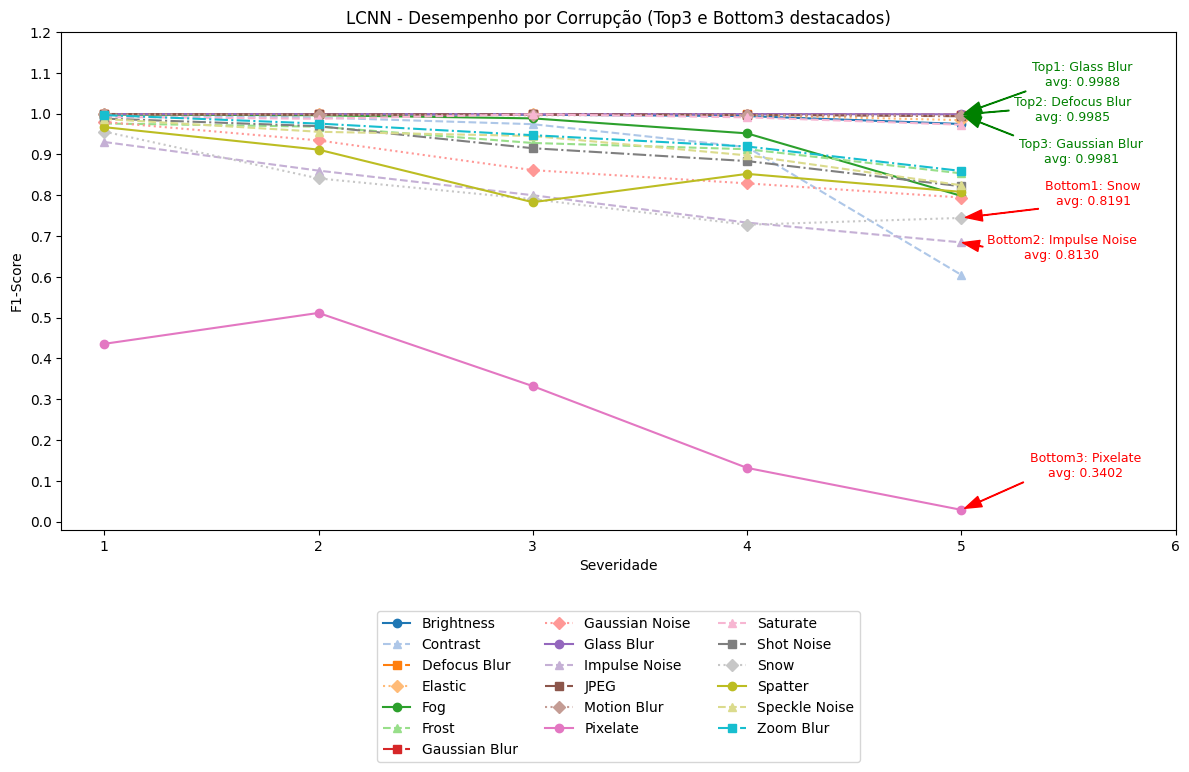

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Caminho do arquivo .xlsx
# caminho_arquivo = r"C:/Users/DESKTOP/pesquisaGabriel/resultadosDasRedes/resultado_final_geral_bancosCorrompidos_ResNet50ModeloEscolhido.xlsx"
archive_path = "../../v2/results/results_corrupted_data_efficientNetB0.xlsx"

# Nome das colunas que você deseja extrair
colunas_desejadas = ['corruption', 'acuracia', 'f1-score']

# Ler o arquivo Excel e selecionar as colunas desejadas
df = pd.read_excel(archive_path, usecols=colunas_desejadas)

# Criar um novo DataFrame vazio
novodf = pd.DataFrame(columns=['corruption', 'somaDasAcuracia', 'qtdItens'])

# Função para verificar se uma string já existe na coluna 'corruption'
def verifica_corrupcao_existente(df, string):
    return string in df['corruption'].values

def get_prefix_before_severity(text):
    parts = text.split("severity", 1)
    return parts[0].strip()

# Iterar sobre as linhas do DataFrame
for index, row in df.iterrows():
    string = get_prefix_before_severity(row['corruption'])
    if verifica_corrupcao_existente(novodf, string):
        novodf.loc[novodf['corruption'] == string, 'somaDasAcuracia'] += row['acuracia']
        novodf.loc[novodf['corruption'] == string, 'qtdItens'] += 1
    else:
        nova_linha = pd.DataFrame({'corruption': [string], 'somaDasAcuracia': [row['acuracia']], 'qtdItens': [1]})
        novodf = pd.concat([novodf, nova_linha], ignore_index=True)

# Criar um novo DataFrame para as médias
novodf2 = pd.DataFrame(columns=['corruption', 'acuraciaMediaDasCorrupcoes'])

# Iterar sobre as linhas do DataFrame
for index, row in novodf.iterrows():
    nova_linha = pd.DataFrame({'corruption': [row['corruption']], 'acuraciaMediaDasCorrupcoes': [row['somaDasAcuracia'] / row['qtdItens']]})
    novodf2 = pd.concat([novodf2, nova_linha], ignore_index=True)

# Ordenar o DataFrame pela coluna 'acuraciaMediaDasCorrupcoes' em ordem decrescente
novodf2 = novodf2.sort_values(by='acuraciaMediaDasCorrupcoes', ascending=False)

# Pegar as 3 melhores e as 3 piores corrupções
top_3_melhores = novodf2.head(3)
top_3_piores = novodf2.tail(3)

# Exibir os resultados
print("\n3 melhores corrupções:")
print(top_3_melhores)

print("\n3 piores corrupções:")
print(top_3_piores)

# Criar um DataFrame para o gráfico
novodf_grafico = pd.DataFrame(columns=['corruption', 'severidade', 'f1-score'])

# Iterar sobre as linhas do DataFrame original
for index, row in df.iterrows():
    string = row['corruption']
    parts = string.split()
    corrupcao = ''
    severidade = 0
    if len(parts) == 3:
        corrupcao = parts[0]
        severidade = int(parts[2])
    elif len(parts) == 4:
        corrupcao = parts[0] + " " + parts[1]
        severidade = int(parts[3])
    novodf_grafico.loc[index] = [corrupcao, severidade, row['f1-score']]

# Criar o gráfico
plt.figure(figsize=(12, 8))

# Lista de cores únicas para as linhas
cores = plt.cm.tab20.colors

# Lista de estilos de linhas e marcadores
linestyles = ['-', '--', '-.', ':']
markers = ['o', '^', 's', 'D']

# Dicionário para mapear cada corrupção a uma cor única
cor_mapping = {}
cor_index = 0

# Agrupar os dados por corrupção
for i, (name, group) in enumerate(novodf_grafico.groupby('corruption')):
    group = group.sort_values(by='severidade')
    if name not in cor_mapping:
        cor_mapping[name] = cores[cor_index]
        cor_index = (cor_index + 1) % len(cores)
    linestyle = linestyles[i % len(linestyles)]
    marker = markers[i % len(markers)]
    plt.plot(group['severidade'], group['f1-score'], marker=marker, linestyle=linestyle, label=name, color=cor_mapping[name])

# Adicionar rótulos e título
plt.xlabel('Severidade')
plt.ylabel('F1-Score')
plt.title('LCNN - Desempenho por Corrupção (Top3 e Bottom3 destacados)')

# Definir os ticks do eixo x como 1, 2, 3, 4, 5
plt.xticks([1, 2, 3, 4, 5, 6])

# Adicionar mais ticks no eixo y
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])

# Adicionar a legenda embaixo do gráfico
legenda = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Lista para armazenar as anotações
annotations = []

# Adicionar anotações para as 3 melhores corrupções (Top1, Top2, Top3)
for i, (index, row) in enumerate(top_3_melhores.iterrows(), start=1):
    corrupcao = row['corruption']
    media = row['acuraciaMediaDasCorrupcoes']
    dados_corrupcao = novodf_grafico[novodf_grafico['corruption'] == corrupcao]
    if not dados_corrupcao.empty:
        severidade = dados_corrupcao['severidade'].max()
        f1_score = dados_corrupcao[dados_corrupcao['severidade'] == severidade]['f1-score'].values[0]
        annotations.append(plt.annotate(f'Top{i}: {corrupcao}\navg: {media:.4f}', 
                                        xy=(severidade, f1_score), 
                                        xytext=(severidade + 0.2, f1_score - 0.05), 
                                        arrowprops=dict(facecolor='green', edgecolor='green', shrink=0.05, width = 0.4, headwidth = 8),
                                        fontsize=9, color='green'))

# Adicionar anotações para as 3 piores corrupções (Bottom1, Bottom2, Bottom3)
for i, (index, row) in enumerate(top_3_piores.iterrows(), start=1):
    corrupcao = row['corruption']
    media = row['acuraciaMediaDasCorrupcoes']
    dados_corrupcao = novodf_grafico[novodf_grafico['corruption'] == corrupcao]
    if not dados_corrupcao.empty:
        severidade = dados_corrupcao['severidade'].max()
        f1_score = dados_corrupcao[dados_corrupcao['severidade'] == severidade]['f1-score'].values[0]
        annotations.append(plt.annotate(f'Bottom{i}: {corrupcao}\navg: {media:.4f}', 
                                        xy=(severidade, f1_score), 
                                        xytext=(severidade + 0.2, f1_score + 0.05), 
                                        arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05, width = 0.4, headwidth = 8),
                                        fontsize=9, color='red'))

# Ajustar as anotações para evitar sobreposição
adjust_text(annotations, 
            arrowprops=dict(arrowstyle='->', color='none'), 
            expand_points=(0.0, 0.0),  # Aumenta a distância entre as anotações
            expand_text=(0.0, 0.0),    # Aumenta o espaço ao redor do texto
            force_text=(-5, 2),     # Força o ajuste do texto
            force_points=(0.00, 0.00))   # Força o ajuste dos pontos

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar o gráfico em um arquivo
caminho_grafico = "../../v2/results/grafico_efficientNetB0_corrupcoes.png"
plt.savefig(caminho_grafico, dpi=500, bbox_inches='tight')  # dpi=300 para alta qualidade
print(f"Gráfico salvo em: {caminho_grafico}")

# Mostrar o gráfico
plt.show()